In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [3]:
horses2 = pd.read_csv('./data/horses2.csv')
horses1 = pd.read_csv('./data/horses1.csv')
horses0 = pd.read_csv('./data/horses.csv')

/var/folders/wg/0kpf4bq56tn3zqg0vq6863980000gn/T/ipykernel_58688/3169756296.py:2: DtypeWarning: Columns (16,17,18,19,20,21,22,96) have mixed types. Specify dtype option on import or set low_memory=False.
  horses1 = pd.read_csv('./data/horses1.csv')


In [4]:
def horses_preprocess(dfs):
    dfs_processed = []
    for df in dfs:
        df = df.copy()
        df = df[['Winner','StartingOdds','RecentWinPercent','Class','laststart']]
        median = df.median()
        df.fillna(median, inplace=True)
        dfs_processed.append(df)
    return pd.concat(dfs_processed, axis=0)

horses = horses_preprocess([horses1, horses2, horses0])
horses.to_csv('./data/clean_data.csv', index=False)

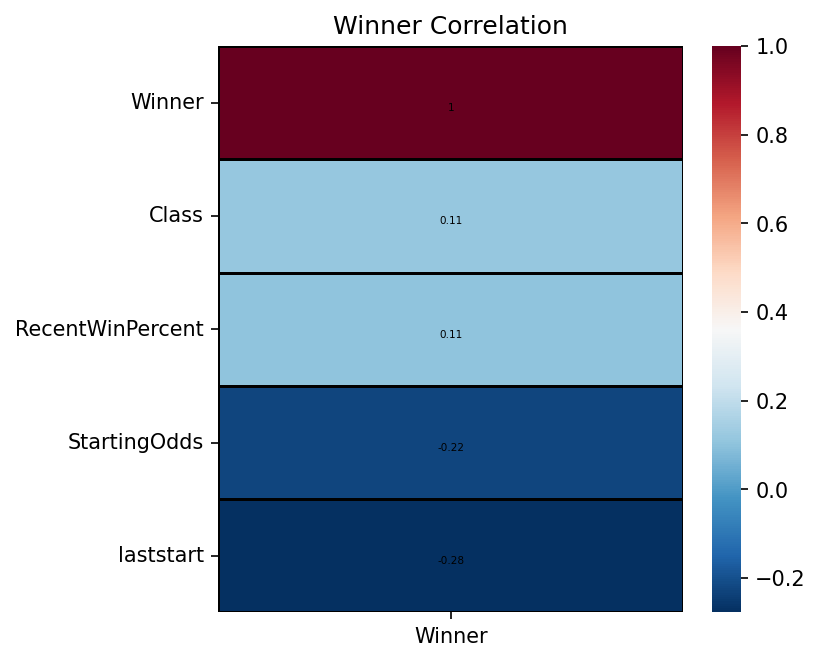

In [5]:
corr = horses.corr().sort_values(by='Winner', ascending=False)
winner_corr = corr[['Winner']]
fig, ax = plt.subplots(figsize=(5,5), dpi=150)
annot_kws = {"ha": 'center',"va": 'top', "size":5, "color": "black"}
ax = sns.heatmap(winner_corr, annot=True, vmax=winner_corr.max(), vmin=winner_corr.min(), square=False, cbar=True, cmap='RdBu_r', linewidths=0.5, linecolor='black', annot_kws=annot_kws)
ax.set_title('Winner Correlation')
plt.show()

In [6]:
horses.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1220095 entries, 0 to 640514
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Winner            1220095 non-null  float64
 1   StartingOdds      1220095 non-null  float64
 2   RecentWinPercent  1220095 non-null  float64
 3   Class             1220095 non-null  float64
 4   laststart         1220095 non-null  float64
dtypes: float64(5)
memory usage: 55.9 MB


In [7]:
x = horses.drop(['Winner'], axis=1)
y = horses['Winner']
x = pd.DataFrame(StandardScaler().fit_transform(x), columns=x.columns)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=53)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

In [8]:
lr = LogisticRegression(solver='newton-cg').fit(x_train, y_train)
print(f'Logistic Regression: {round(lr.score(x_test, y_test)*100)}%')

Logistic Regression: 91%


In [9]:
input = tf.keras.Input(shape=(x.shape[1],))
x = tf.keras.layers.Dense(8, activation='relu')(input)
x = tf.keras.layers.Dense(4, activation='relu')(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
nn_model = tf.keras.Model(input, output)
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
nn_model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), verbose=1)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Epoch 1/10


2022-06-26 08:59:22.914856: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-26 08:59:22.914981: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-06-26 08:59:23.020271: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-26 08:59:23.298157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


34316/34316 [==============================] - ETA: 0s - loss: 0.2200 - accuracy: 0.9153

2022-06-26 09:02:41.048507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


34316/34316 [==============================] - 220s 6ms/step - loss: 0.2200 - accuracy: 0.9153 - val_loss: 0.2036 - val_accuracy: 0.9246
Epoch 2/10
34316/34316 [==============================] - 221s 6ms/step - loss: 0.2026 - accuracy: 0.9229 - val_loss: 0.2006 - val_accuracy: 0.9245
Epoch 3/10
34316/34316 [==============================] - 221s 6ms/step - loss: 0.2008 - accuracy: 0.9240 - val_loss: 0.1985 - val_accuracy: 0.9266
Epoch 4/10
34316/34316 [==============================] - 220s 6ms/step - loss: 0.1996 - accuracy: 0.9252 - val_loss: 0.2020 - val_accuracy: 0.9246
Epoch 5/10
34316/34316 [==============================] - 220s 6ms/step - loss: 0.1988 - accuracy: 0.9258 - val_loss: 0.1974 - val_accuracy: 0.9269
Epoch 6/10
34316/34316 [==============================] - 221s 6ms/step - loss: 0.1984 - accuracy: 0.9258 - val_loss: 0.1981 - val_accuracy: 0.9256
Epoch 7/10
34316/34316 [==============================] - 220s 6ms/step - loss: 0.1981 - accuracy: 0.9260 - val_loss: 0.197

In [10]:
nn_model.evaluate(x_test, y_test)

3813/3813 [==============================] - 15s 4ms/step - loss: 0.1987 - accuracy: 0.9255


[0.19866728782653809, 0.9255471229553223]

In [11]:
nn_model.save_weights('./checkpoints/my_checkpoint')